In [8]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from forex_python.converter import CurrencyRates
import ta

In [9]:
# Define the time period for data
end_date = datetime.now()
start_date = datetime(1990, 1, 1)  # Start date from 1990

In [10]:
# Download Exxon Mobil Corp data
xom = yf.download('XOM', start=start_date, end=end_date)

# Calculate moving averages
xom['50_day_MA'] = xom['Close'].rolling(window=50).mean()
xom['200_day_MA'] = xom['Close'].rolling(window=200).mean()

[*********************100%%**********************]  1 of 1 completed


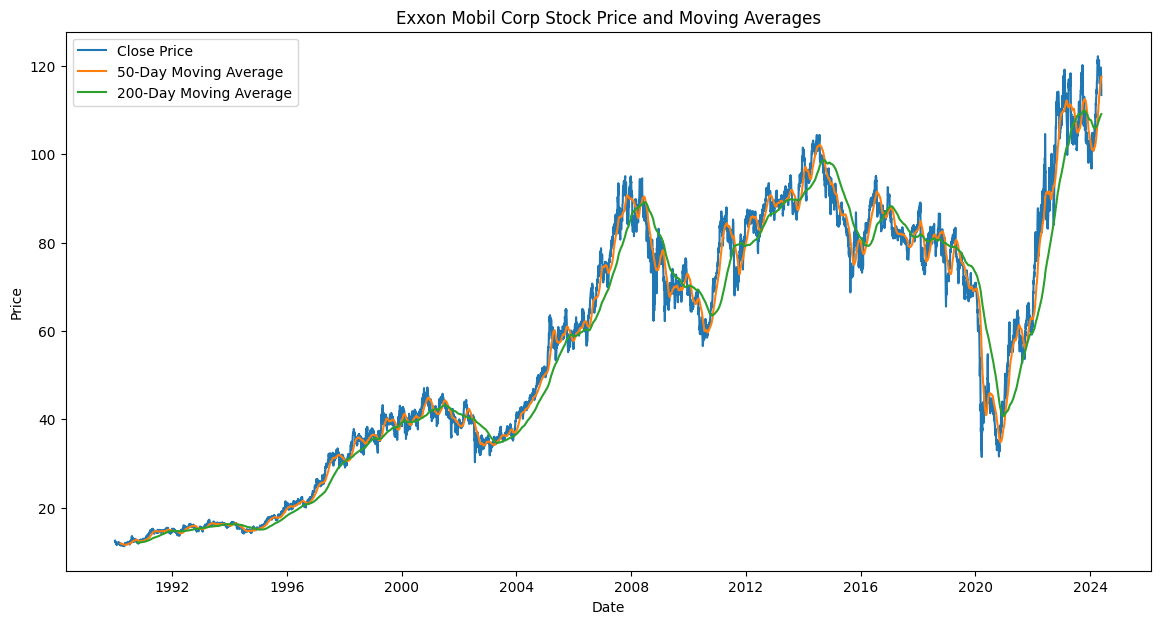

In [11]:
# Plot historical stock prices and moving averages
plt.figure(figsize=(14, 7))
plt.plot(xom['Close'], label='Close Price')
plt.plot(xom['50_day_MA'], label='50-Day Moving Average')
plt.plot(xom['200_day_MA'], label='200-Day Moving Average')
plt.title('Exxon Mobil Corp Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [12]:
# Get financial statements
xom_ticker = yf.Ticker('XOM')
financials = xom_ticker.financials.T
financials = financials.reindex(xom.index, method='ffill')

# # Get dividend information
# dividends = xom_ticker.dividends.reindex(xom.index, method='ffill')

# Get macroeconomic features from FRED
macro_vars = ['CPIAUCSL', 'UNRATE', 'FEDFUNDS', 'GDP', 'DGS10', 'DTWEXBGS', 'M2', 'PCE', 'CPILFESL', 'HOUST']
macro_data = web.DataReader(macro_vars, 'fred', start_date, end_date)
macro_data.fillna(method='ffill', inplace=True)

# # Get exchange rates
# c = CurrencyRates()
# exchange_rate = c.get_rate('USD', 'EUR')  # Example exchange rate USD to EUR

C:\Users\hesen\AppData\Local\Temp\ipykernel_71964\852015720.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='ffill', inplace=True)


In [13]:
# Merge all data
data = xom.join([financials, macro_data])

# Drop rows with missing values
data.dropna(inplace=True)

In [14]:
# Add technical indicators
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
data['MACD'] = ta.trend.macd(data['Close'])
data['Bollinger_Upper'] = ta.volatility.bollinger_hband(data['Close'])
data['Bollinger_Lower'] = ta.volatility.bollinger_lband(data['Close'])

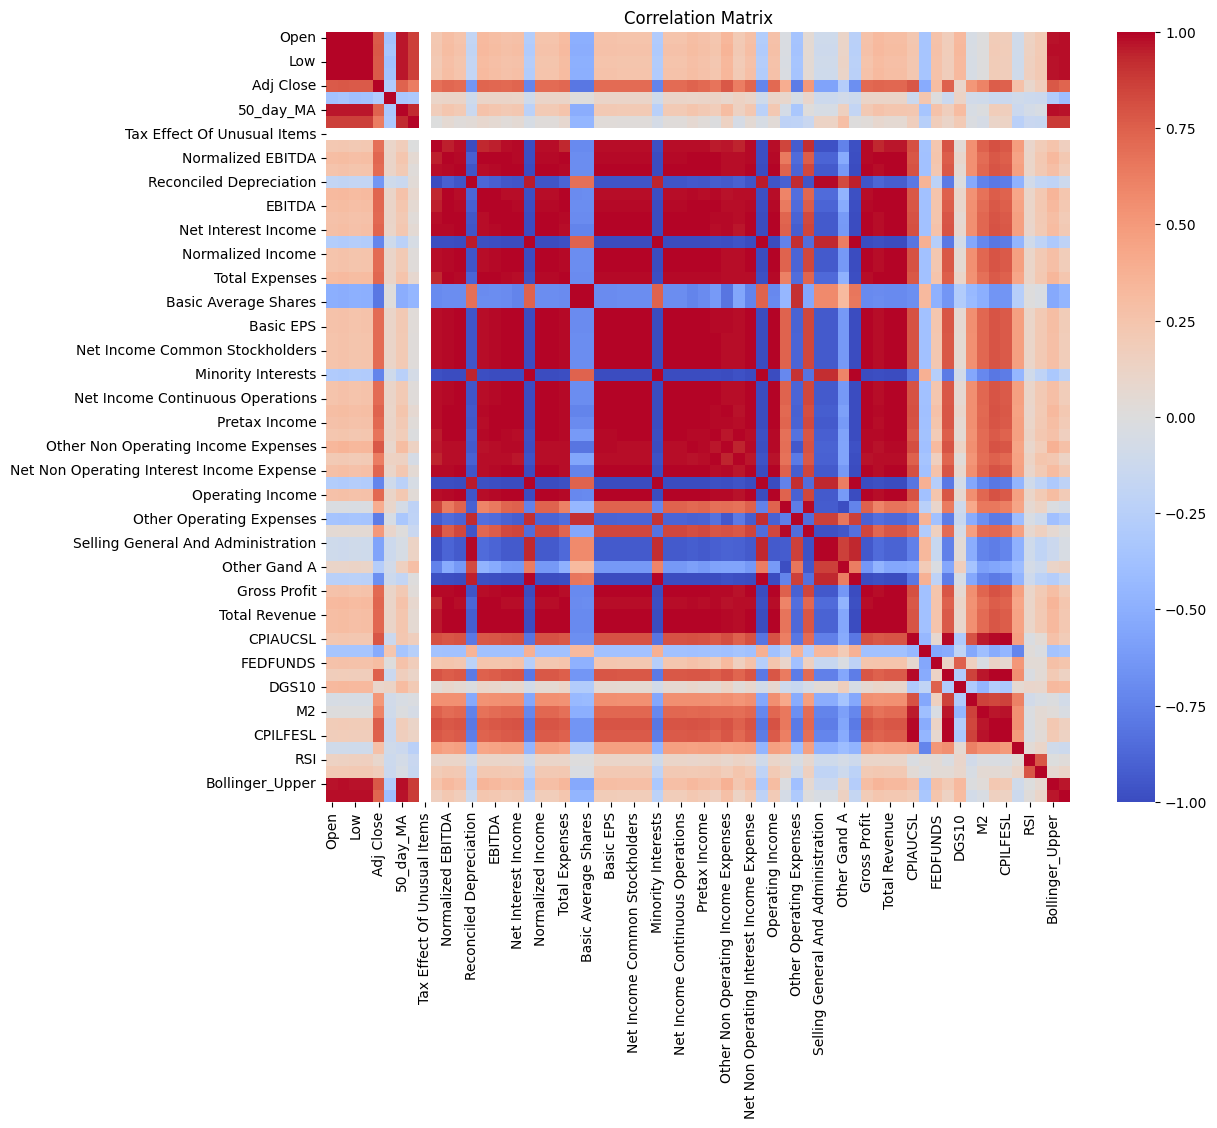

In [35]:
# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [16]:
# Drop rows where any of the elements is NaN
data = data.dropna()

In [17]:
# Define features and target
features = data.drop(columns=['Adj Close', 'Volume', 'Close'])
target = data['Close']

In [18]:
# Split data into training and testing sets
train_data = data[data.index < datetime(2023, 1, 1)]
test_data = data[data.index >= datetime(2023, 1, 1)]

In [19]:
X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close']
X_test = test_data.drop(columns=['Close'])
y_test = test_data['Close']

In [20]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [21]:
# AdaBoost
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada = AdaBoostRegressor()
ada_grid = GridSearchCV(ada, ada_params, scoring=mse_scorer, cv=5)
ada_grid.fit(X_train_scaled, y_train)
ada_best = ada_grid.best_estimator_
ada_predictions = ada_best.predict(X_test_scaled)
ada_mse = mean_squared_error(y_test, ada_predictions)
print(f"AdaBoost MSE: {ada_mse}, Best Params: {ada_grid.best_params_}")

AdaBoost MSE: 10.25611430129391, Best Params: {'learning_rate': 0.1, 'n_estimators': 200}


In [22]:
# Gradient Boosting
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
gb = GradientBoostingRegressor()
gb_grid = GridSearchCV(gb, gb_params, scoring=mse_scorer, cv=5)
gb_grid.fit(X_train_scaled, y_train)
gb_best = gb_grid.best_estimator_
gb_predictions = gb_best.predict(X_test_scaled)
gb_mse = mean_squared_error(y_test, gb_predictions)
print(f"Gradient Boosting MSE: {gb_mse}, Best Params: {gb_grid.best_params_}")

Gradient Boosting MSE: 3.2661374397622964, Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}


In [23]:
# XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb = XGBRegressor(objective='reg:squarederror')
xgb_grid = GridSearchCV(xgb, xgb_params, scoring=mse_scorer, cv=5)
xgb_grid.fit(X_train_scaled, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_predictions = xgb_best.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
print(f"XGBoost MSE: {xgb_mse}, Best Params: {xgb_grid.best_params_}")

XGBoost MSE: 3.9070729759437963, Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [24]:
# LightGBM
lgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 40]
}
lgbm = lgb.LGBMRegressor()
lgb_grid = GridSearchCV(lgbm, lgb_params, scoring=mse_scorer, cv=5)
lgb_grid.fit(X_train_scaled, y_train)
lgb_best = lgb_grid.best_estimator_
lgb_predictions = lgb_best.predict(X_test_scaled)
lgb_mse = mean_squared_error(y_test, lgb_predictions)
print(f"LightGBM MSE: {lgb_mse}, Best Params: {lgb_grid.best_params_}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4559
[LightGBM] [Info] Number of data points in the train set: 3403, number of used features: 62
[LightGBM] [Info] Start training from score 77.972753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4572
[LightGBM] [Info] Number of data points in the train set: 3403, number of used features: 62
[LightGBM] [Info] Start training from score 78.254934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4572
[LightGBM] [Info] Number of data points in the train set: 3403, number of used features: 62
[LightGBM] [Info] Start trai

In [29]:
# CatBoost
cat_params = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7]
}
cat = CatBoostRegressor(verbose=0)
cat_grid = GridSearchCV(cat, cat_params, scoring=mse_scorer, cv=5)
cat_grid.fit(X_train_scaled, y_train)
cat_best = cat_grid.best_estimator_
cat_predictions = cat_best.predict(X_test_scaled)
cat_mse = mean_squared_error(y_test, cat_predictions)
print(f"CatBoost MSE: {cat_mse}, Best Params: {cat_grid.best_params_}")

CatBoost MSE: 5.212198976300194, Best Params: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.1}


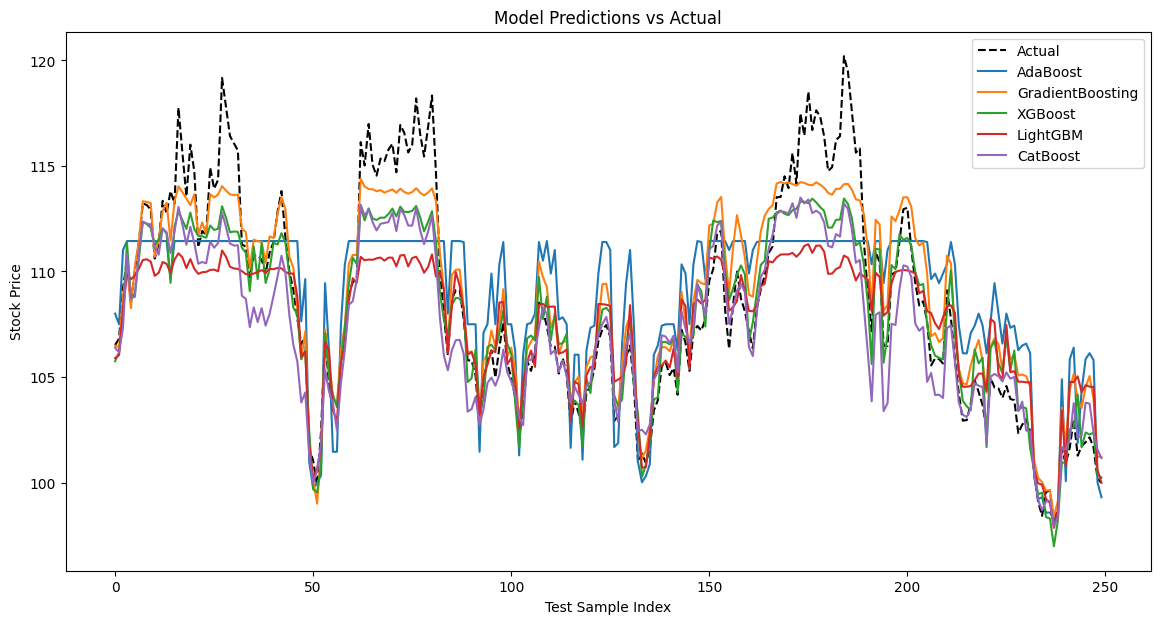

In [34]:
# Plotting the predictions of each model
models_predictions = {
    'AdaBoost': ada_predictions,
    'GradientBoosting': gb_predictions,
    'XGBoost': xgb_predictions,
    'LightGBM': lgb_predictions,
    'CatBoost': cat_predictions
}

plt.figure(figsize=(14, 7))

plt.plot(y_test.values, label='Actual', color='black', linestyle='--')
for model_name, predictions in models_predictions.items():
    plt.plot(predictions, label=model_name)
plt.title('Model Predictions vs Actual')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

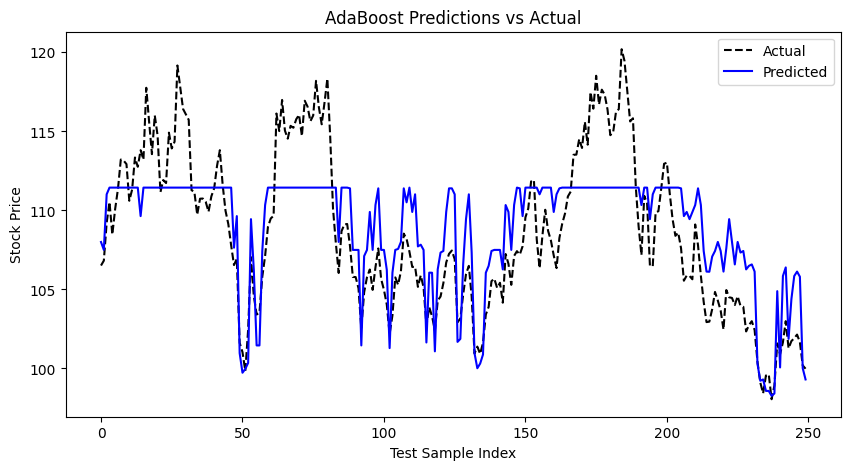

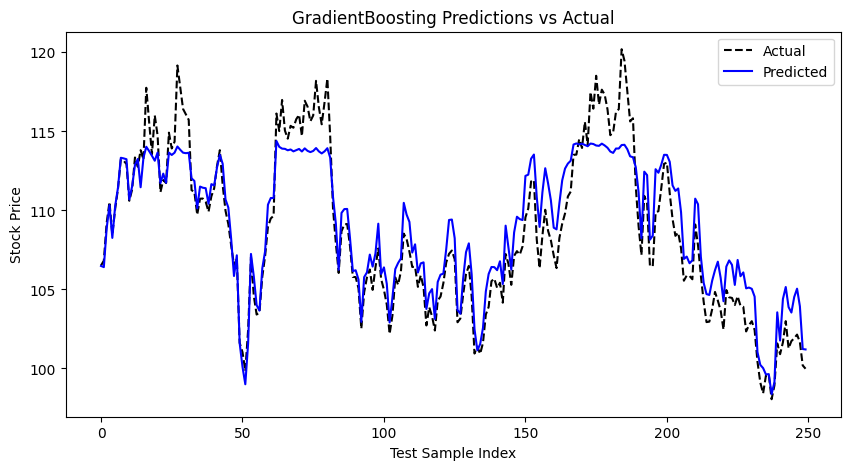

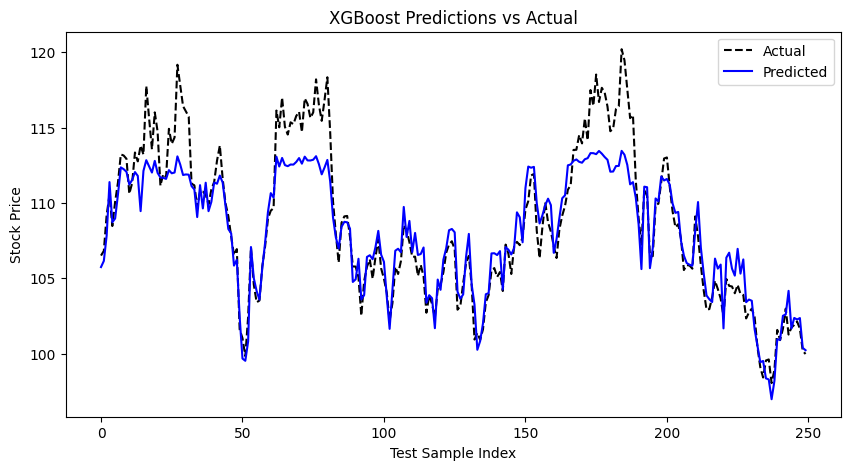

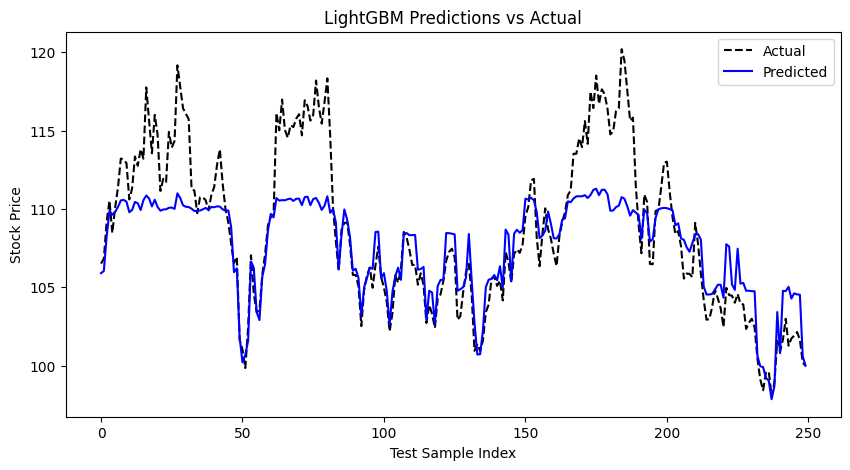

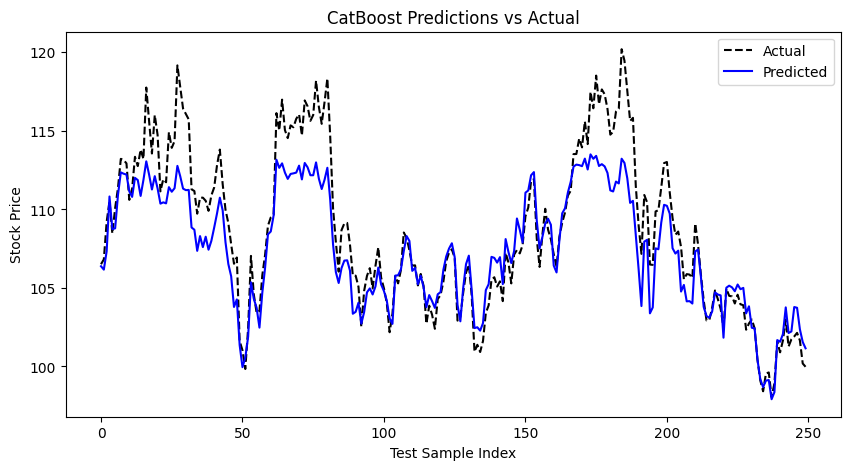

Model Performance:
AdaBoost MSE: 10.25611430129391, Best Params: {'learning_rate': 0.1, 'n_estimators': 200}
Gradient Boosting MSE: 3.2661374397622964, Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
XGBoost MSE: 3.9070729759437963, Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
LightGBM MSE: 8.693740382984231, Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 50, 'num_leaves': 100}
CatBoost MSE: 5.212198976300194, Best Params: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.1}


In [27]:
# Display individual prediction vs actual plots
for model_name, predictions in models_predictions.items():
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Actual', color='black', linestyle='--')
    plt.plot(predictions, label='Predicted', color='blue')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Display results
print("Model Performance:")
print(f"AdaBoost MSE: {ada_mse}, Best Params: {ada_grid.best_params_}")
print(f"Gradient Boosting MSE: {gb_mse}, Best Params: {gb_grid.best_params_}")
print(f"XGBoost MSE: {xgb_mse}, Best Params: {xgb_grid.best_params_}")
print(f"LightGBM MSE: {lgb_mse}, Best Params: {lgb_grid.best_params_}")
print(f"CatBoost MSE: {cat_mse}, Best Params: {cat_grid.best_params_}")